In [18]:
%pylab inline

from pandas import read_csv
from IPython.display import HTML, display, Javascript

def hide():
    """I found the code for this feature here: http://blog.nextgenetics.net/?e=102"""
    return HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.output_prompt').hide();
 } else {
 $('div.input').show();
 $('div.output_prompt').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<div align = "center">
The raw code for this IPython notebook is by default hidden for easier reading.

To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
</div>
''')


disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

display(Javascript(disable_js))
hide()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<IPython.core.display.Javascript object>

In [2]:
medicare = read_csv("Medicare_a_CY2013b.csv", header = True)

<h1>Medicare Provider Utilization and Payment Data</h1>

The U.S. government has released a data set to inform the public on services and procedures provided to Medicare beneficiaries by physicians and other healthcare professionals. This was done to improve our healthcare system by making it more transparent and accountable and to hopefully help make our healthcare more affordable in the future.

The source for the data was https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Physician-and-Other-Supplier.html

I also used Wikipedia to get demographic data for the United States: https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population

The data set provided at www.cms.gov is large and has been helpfully broken down into more easily consumable data sets. This was done by first of all dividing the data into year and then further dividing the data based on the last name of the service provider.

Because of the large size of the data, I decided to focus on only the year 2013 (the last year that information is available) and only service providers with a last name starting with the letter "A". However, even just the letter "A" was too big for my aging computer to handle, so I only used the first 300,000 entries in the data set. This was still 7 MB of data, but at least it was manageable.

To get a sense of what the data contains, below you will see one row of it: 

`
npi                                          1003002494
nppes_provider_last_org_name                   ANDERSON
nppes_provider_first_name                        JOSEPH
nppes_provider_mi                                     M
nppes_credentials                                  M.D.
nppes_provider_gender                                 M
nppes_entity_code                                     I
nppes_provider_street1                         802 B ST
nppes_provider_street2                              NaN
nppes_provider_city                          SAN RAFAEL
nppes_provider_zip                            949013026
nppes_provider_state                                 CA
nppes_provider_country                               US
provider_type                                 Pathology
medicare_participation_indicator                      Y
place_of_service                                      O
hcpcs_code                                        88342
hcpcs_description                   
       Tissue or cell analysis by immunologic technique
 hcpcs_drug_indicator                                 N 
 line_srvc_cnt                                      255 
 bene_unique_cnt                                     37 
 bene_day_srvc_cnt                                   37 
average_Medicare_allowed_amt                    $145.57
stdev_Medicare_allowed_amt                        $0.00
average_submitted_chrg_amt                      $257.00
stdev_submitted_chrg_amt                          $0.00
average_Medicare_payment_amt                    $115.52
stdev_Medicare_payment_amt                        $3.00
`

There is a lot of details that we can look at in this dataset, I have decided to concentrate my attention on two areas:

One, I want to examine which types of Provider charge the most amount of money.

Two, I want to see where Medicare is used the most and the least in the country.


<h2>Where is the Money Going?</h2>

In the graph below, we can see the average payment cost of a service

In [3]:
avg_allowed = array([0 for i in range(len(medicare))])
for i in range(len(medicare)):
    s = medicare["average_Medicare_allowed_amt"][i][1:]
    if(len(s)>6):
        avg_allowed[i] = float(s[:len(s)-7]+s[len(s)-6:])
    else:
        avg_allowed[i] = float(s)        
avg_payment = array([0 for i in range(len(medicare))])
for i in range(len(medicare)):
    s = medicare["average_Medicare_payment_amt"][i][1:]
    if(len(s)>6):
        avg_payment[i] = float(s[:len(s)-7]+s[len(s)-6:])
    else:
        avg_payment[i] = float(s)

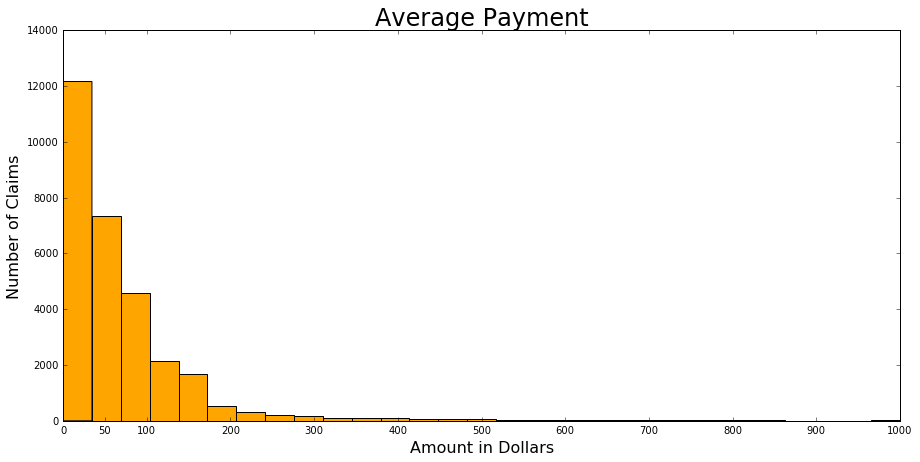

In [4]:
figsize(15,7)
hist(avg_payment, bins = linspace(0,1000,30), color = "orange")
title("Average Payment", fontsize = 24)
xticks([0,50,100,200,300,400,500,600,700,800,900, 1000])
xlabel("Amount in Dollars",fontsize = 16)
ylabel("Number of Claims", fontsize = 16)
None

What we can see from this plot is that the average payment per service follows a power law. What this means is that while most claims are cheap, the expensive claims add a disproportionate amount to the total cost that Medicare is paying out.

In fact, if we simply cap how much a service may charge, we can have considerable savings. In the graph below, I have plotted the percentage of expenditures above certain thresholds. 

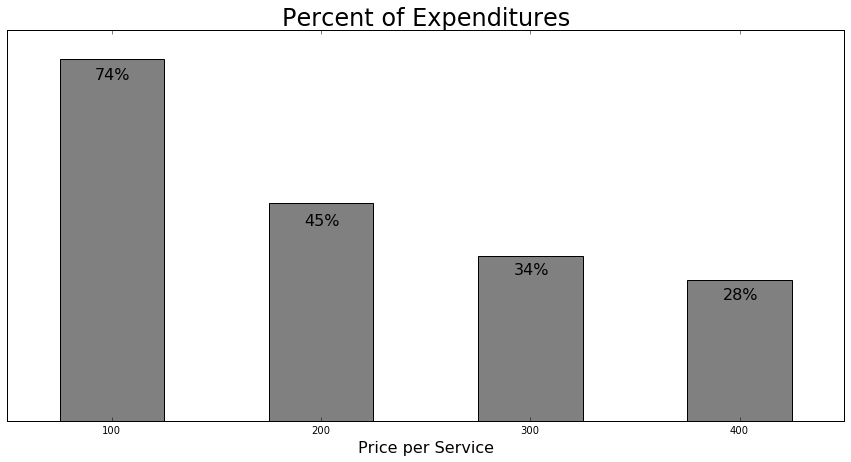

In [5]:
tot = sum(avg_allowed)
mean_all = mean(avg_allowed)
hundred = sum(avg_allowed[avg_allowed>100])/tot
two_hundred = sum(avg_allowed[avg_allowed>200])/tot
three_hundred = sum(avg_allowed[avg_allowed>300])/tot
four_hundred = sum(avg_allowed[avg_allowed>400])/tot
bar([100,200,300,400], [hundred, two_hundred,three_hundred, four_hundred], width = 50,\
    align = "center", color = "grey")
text(92,0.7,str(int(round(hundred,2)*100))+"%", fontsize = 16)
text(192,0.4,str(int(round(two_hundred,2)*100))+"%", fontsize = 16)
text(292,0.3,str(int(round(three_hundred,2)*100))+"%", fontsize = 16)
text(392,0.25,str(int(round(four_hundred,2)*100))+"%", fontsize = 16)
title("Percent of Expenditures", fontsize = 24)
xticks([100,200,300,400])
yticks([])
xlabel("Price per Service",fontsize = 16)
None

What the above plot shows is that, for example, 75% of all the money expended by Medicare is spent on services that cost more than $100. 

If we simply were able to cap all Medicare services at $100, the Medicare system would save a tremendous amount.

However, before taking any such drastic measures, it would be beneficial to see exactly which Service Providers are charging the most.

Below is a plot that shows how much the average service is by what type of service they provide.

In [6]:
p_type = medicare.groupby(["provider_type"])
allowed = p_type["average_Medicare_allowed_amt"].apply(lambda x : x.tolist())

In [7]:
def make_float(ls):
    out = []
    for s in ls:
        s = s[1:]
        if(len(s)>9):
            out.append(float(s[:len(s) - 11]+s[len(s)-10:len(s)-7]+s[len(s)-6:]))
        elif(len(s)>6):
            out.append(float(s[:len(s)-7]+s[len(s)-6:]))
        else:
            out.append(float(s))
    return out

allowed = allowed.apply(make_float)

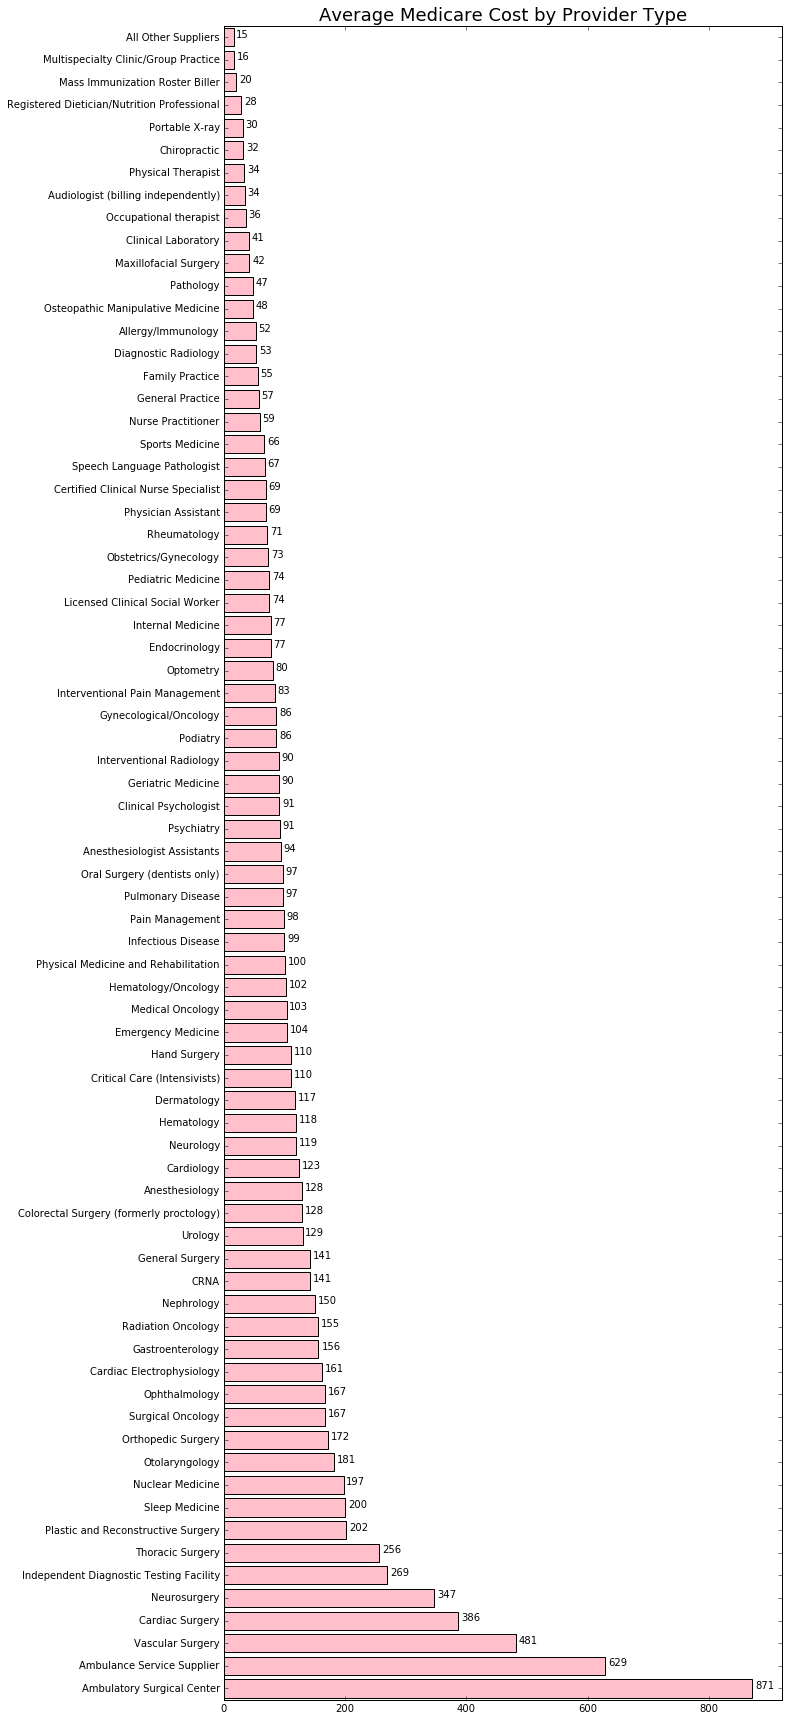

In [17]:
mean_allowed = allowed.apply(mean)
mean_allowed.sort(ascending = False)
figsize(10,30)
barh(range(len(allowed)), mean_allowed, align = "center", color="pink")
yticks(range(len(allowed)), mean_allowed.index)
ylim(-0.5,len(allowed) - 0.5);
xlim(0,920)
for i in range(len(allowed)):
    text(int(mean_allowed.ix[i])+5,i,int(mean_allowed.ix[i]))
title("Average Medicare Cost by Provider Type", fontsize = 18)
None

A couple of interesting things to note from this plot.

First of all, something that interested me personally was that one can see that a Nurse Practitioners charge more per service than a Family Practitioner or a General Practioner.

We also see that many of the most expensive service are surgery related. 

But the most expensive services are related to ambulances. Let's dig into this a little more.

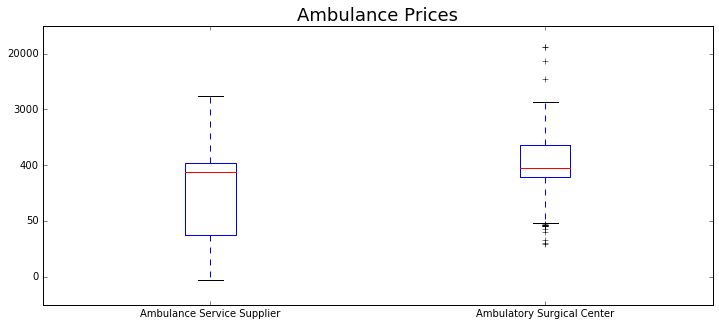

In [9]:
figsize(12,5)
fig, ax = plt.subplots()

boxplot([log(allowed.ix["Ambulance Service Supplier"]), log(allowed.ix["Ambulatory Surgical Center"])],\
       labels = ["Ambulance Service Supplier", "Ambulatory Surgical Center"]);
title("Ambulance Prices", fontsize = 18)
ax.set_yticklabels([2,0,50,400, 3000, 20000])

None

What we can see from this boxplot is that the average price of Ambulance Services has very large outliers, with some services costing in excess of $20,000. 

Below is a sampling of these extremely expensive procedures:

In [16]:
smaller = medicare[medicare["provider_type"] == "Ambulatory Surgical Center"]\
[["average_Medicare_allowed_amt", "hcpcs_description"]]
x = smaller[smaller["average_Medicare_allowed_amt"].apply(len)>9].values
for i in x:
    print(i[1],":", i[0])


Insertion of spinal neurostimulator pulse generator or receiver : $17,087.85
Removal and replacement of dual lead pacing defibrillator pulse generator : $27,684.19
Removal and replacement of multiple lead pacing defibrillator pulse generator : $27,684.19


These seem like pretty involved procedures, but I still question their cost.

<h1>Geographic Considerations</h1>

Another point of interest is how different States and geographic areas utilize Medicare services.

Below I have plotted the number of Medicare claims per State. 

In [11]:

p_type = medicare.groupby(["nppes_provider_state"])
number_of_claims = p_type["average_Medicare_allowed_amt"].apply(lambda x : x.tolist()).apply(lambda x : len(x))

In [12]:
states = """CA	1	38,332,521
TX	2	26,448,193
NY	3	19,651,127
FL	4	19,552,860
IL	5	12,882,135
PA	6	12,773,801
OH	7	11,570,808
GA	8	9,992,167
MI	9	9,895,622
NC	10	9,848,060
NJ	11	8,899,339
VA	12	8,260,405
WA	13	6,971,406
MA	14	6,692,824
AZ	15	6,626,624
IN	16	6,570,902
TN	17	6,495,978
MO	18	6,044,171
MD	19	5,928,814
WI	20	5,742,713
MN	21	5,420,380
CO	22	5,268,367
AL	23	4,833,722
SC	24	4,774,839
LA	25	4,625,470
KY	26	4,395,295
OR	27	3,930,065
OK	28	3,850,568
CT	29	3,596,080
IA	30	3,090,416
MS	31	2,991,207
AR	32	2,959,373
UT	33	2,900,872
KS	34	2,893,957
NV	35	2,790,136
NM	36	2,085,287
NE	37	1,868,516
WV	38	1,854,304
ID	39	1,612,136
HI	40	1,404,054
ME	41	1,328,302
NH	42	1,323,459
RI	43	1,051,511
MT	44	1,015,165
DE	45	925,749
SD	46	844,877
AK	47	735,132
ND	48	723,393
DC	49	646,449
VT	50	626,630
WY	51	582,658"""
states = states.split("\n")
states = [x.split("\t") for x in states]
cleaned_states = {}
import re
for x in states:
    cleaned_states[x[0]] = int(re.sub(",","",x[2]))


cleaned_states["PR"] = 3458000

In [13]:
state_abr = """Alabama	Ala.	AL
Alaska	Alaska	AK
American Samoa	 	AS
Arizona	Ariz.	AZ
Arkansas	Ark.	AR
California	Calif.	CA
Colorado	Colo.	CO
Connecticut	Conn.	CT
Delaware	Del.	DE
District of Columbia	D.C.	DC
Florida	Fla.	FL
Georgia	Ga.	GA
Guam	Guam	GU
Hawaii	Hawaii	HI
Idaho	Idaho	ID
Illinois	Ill.	IL
Indiana	Ind.	IN
Iowa	Iowa	IA
Kansas	Kans.	KS
Kentucky	Ky.	KY
Louisiana	La.	LA
Maine	Maine	ME
Maryland	Md.	MD
Marshall Islands	 	MH
Massachusetts	Mass.	MA
Michigan	Mich.	MI
Micronesia	 	FM
Minnesota	Minn.	MN
Mississippi	Miss.	MS
Missouri	Mo.	MO
Montana	Mont.	MT
Nebraska	Nebr.	NE
Nevada	Nev.	NV
New Hampshire	N.H.	NH
New Jersey	N.J.	NJ
New Mexico	N.M.	NM
New York	N.Y.	NY
North Carolina	N.C.	NC
North Dakota	N.D.	ND
Northern Marianas	 	MP
Ohio	Ohio	OH
Oklahoma	Okla.	OK
Oregon	Ore.	OR
Palau	 	PW
Pennsylvania	Pa.	PA
Puerto Rico	P.R.	PR
Rhode Island	R.I.	RI
South Carolina	S.C.	SC
South Dakota	S.D.	SD
Tennessee	Tenn.	TN
Texas	Tex.	TX
Utah	Utah	UT
Vermont	Vt.	VT
Virginia	Va.	VA
Virgin Islands	V.I.	VI
Washington	Wash.	WA
West Virginia	W.Va.	WV
Wisconsin	Wis.	WI
Wyoming	Wyo.	WY"""
state_to_abr = {}
abr_to_state = {}
state_abr = state_abr.split("\n")
for line in state_abr:
    x = line.split("\t")
    state = x[0]
    abr = x[2]
    state_to_abr[state] = abr
    abr_to_state[abr] = state


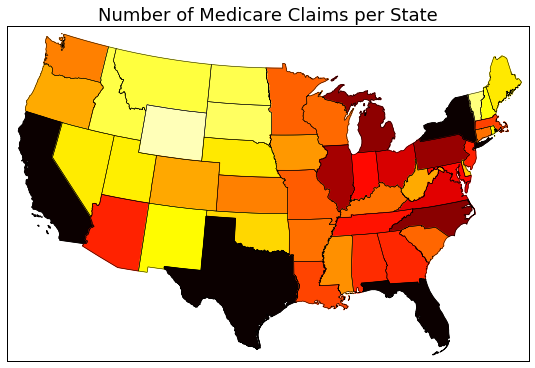

In [14]:
from mpl_toolkits.basemap import Basemap
#see http://matplotlib.org/basemap/

from matplotlib.colors import rgb2hex

all_together_now = {}
for x in number_of_claims.index:
    if((x == "GU") or (x=="MP") or (x == "VI") or (x == "ZZ")): #ZZ is state unknown
        continue
    all_together_now[abr_to_state[x]] ={"pop":cleaned_states[x], \
                          "claims/capita":50000*number_of_claims[x]/cleaned_states[x],\
                         "abr":x, "claims":number_of_claims[x] }

figure(figsize=(12,6))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile('st99_d90','states',drawbounds=True)
colors={}
statenames=[]
cmap = cm.hot 
vmin = 0; vmax = 2000 # set range.

for shapedict in m.states_info:
  statename = shapedict['NAME']
  if statename != 'District of Columbia': 
    pop = all_together_now[statename]["claims"]
    
    colors[statename] = cmap(1.-math.sqrt((pop-vmin)/(vmax-vmin)))[:3]
  statenames.append(statename)

for nshape,seg in enumerate(m.states):

  xx,yy = zip(*seg)
  if statenames[nshape] != 'District of Columbia': # skip DC
     color = rgb2hex(colors[statenames[nshape]]) 
     fill(xx,yy,color,edgecolor=color)

title('Number of Medicare Claims per State', fontsize = 18)
None
    

What should be obvious is that the States with the highest populations also have the most claims.

However, what we should really be interested in is the number of claims per capita in each state. I have controlled for population in the following plot:

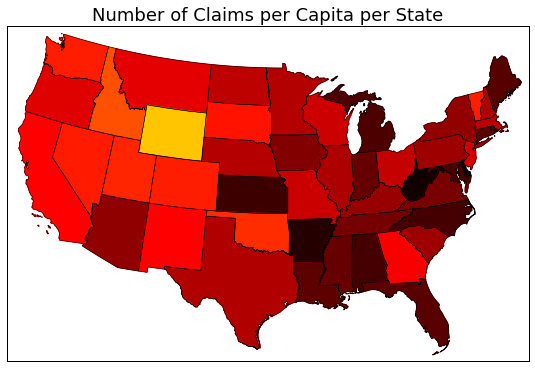

In [15]:
from mpl_toolkits.basemap import Basemap
#see http://matplotlib.org/basemap/

from matplotlib.colors import rgb2hex

all_together_now = {}
for x in number_of_claims.index:
    if((x == "GU") or (x=="MP") or (x == "VI") or (x == "ZZ")): #ZZ is state unknown
        continue
    all_together_now[abr_to_state[x]] ={"pop":cleaned_states[x], \
                          "claims/capita":50000*number_of_claims[x]/cleaned_states[x],\
                         "abr":x, "claims":number_of_claims[x] }

figure(figsize=(12,6))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile('st99_d90','states',drawbounds=True)
colors={}
statenames=[]
cmap = cm.hot 
vmin = 0; vmax = 8 # set range.

for shapedict in m.states_info:
  statename = shapedict['NAME']
  if statename != 'District of Columbia': 
    pop = all_together_now[statename]["claims/capita"]
    
    colors[statename] = cmap(1.-math.sqrt((pop-vmin)/(vmax-vmin)))[:3]
  statenames.append(statename)

for nshape,seg in enumerate(m.states):

  xx,yy = zip(*seg)
  if statenames[nshape] != 'District of Columbia': # skip DC
     color = rgb2hex(colors[statenames[nshape]]) 
     fill(xx,yy,color,edgecolor=color)

title('Number of Claims per Capita per State', fontsize = 18)
None
    


Now, we can see that the Mid-West and the West have fewer claims than on the East and the South.